# Calculate Coverage

You have a large region of interest. You need to identify an AOI for your study. One of the inputs to that decision is the coverage within the region. This notebook will walk you through that process.

In this notebook, we create the coverage map for PS Orthotiles collected in 2017 through August for the state of Iowa. The coverage calculation is performed in WGS84 because it covers a larger area than a single UTM zone.

Ideas for improvements:
- investigate projection

In [1]:
# Notebook dependencies
from __future__ import print_function

import datetime
import copy
# from functools import partial
import os

from IPython.display import display # , Image
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from planet import api
from planet.api import filters
# import pyproj
import rasterio
from rasterio import features as rfeatures
from shapely import geometry as sgeom
# import shapely.ops

%matplotlib inline

## Define AOI

Define the AOI as a geojson polygon. This can be done at [geojson.io](http://geojson.io). If you use geojson.io, only copy the single aoi feature, not the entire feature collection.

In [2]:
iowa = {"geometry": {"type": "Polygon", "coordinates": [[[-91.163064, 42.986781], [-91.14556, 42.90798], [-91.143375, 42.90467], [-91.117411, 42.895837], [-91.100565, 42.883078], [-91.077643, 42.803798], [-91.069549, 42.769628], [-91.064896, 42.757272], [-91.053733, 42.738238], [-90.976314, 42.695996], [-90.949213, 42.685573], [-90.896961, 42.674407], [-90.84391, 42.663071], [-90.769495, 42.651443], [-90.720209, 42.640758], [-90.709204, 42.636078], [-90.702671, 42.630756], [-90.645627, 42.5441], [-90.636727, 42.518702], [-90.636927, 42.513202], [-90.640927, 42.508302], [-90.655927, 42.491703], [-90.656527, 42.489203], [-90.656327, 42.483603], [-90.654027, 42.478503], [-90.646727, 42.471904], [-90.624328, 42.458904], [-90.559451, 42.430695], [-90.477279, 42.383794], [-90.474834, 42.381473], [-90.419027, 42.328505], [-90.416535, 42.325109], [-90.4162, 42.321314], [-90.424326, 42.293326], [-90.430735, 42.284211], [-90.430884, 42.27823], [-90.419326, 42.254467], [-90.391108, 42.225473], [-90.375129, 42.214811], [-90.356964, 42.205445], [-90.349162, 42.204277], [-90.316269, 42.1936], [-90.306531, 42.190439], [-90.234919, 42.165431], [-90.211328, 42.15401], [-90.167533, 42.122475], [-90.162225, 42.11488], [-90.161119, 42.104404], [-90.163405, 42.087613], [-90.168358, 42.075779], [-90.166495, 42.054543], [-90.164537, 42.045007], [-90.154221, 42.033073], [-90.150916, 42.02944], [-90.141167, 42.008931], [-90.140613, 41.995999], [-90.1516, 41.931002], [-90.152104, 41.928947], [-90.181973, 41.80707], [-90.187969, 41.803163], [-90.20844, 41.797176], [-90.222263, 41.793133], [-90.242747, 41.783767], [-90.278633, 41.767358], [-90.302782, 41.750031], [-90.309826, 41.743321], [-90.31522, 41.734264], [-90.317041, 41.729104], [-90.334525, 41.679559], [-90.343162, 41.648141], [-90.34165, 41.621484], [-90.39793, 41.572233], [-90.461432, 41.523533], [-90.474332, 41.519733], [-90.499475, 41.518055], [-90.605937, 41.494232], [-90.655839, 41.462132], [-90.737537, 41.450127], [-90.771672, 41.450761], [-90.786282, 41.452888], [-90.847458, 41.455019], [-90.989976, 41.431962], [-91.027787, 41.423603], [-91.039872, 41.418523], [-91.047819, 41.4109], [-91.078682, 41.336089], [-91.079657, 41.333727], [-91.114186, 41.250029], [-91.113648, 41.241401], [-91.049808, 41.178033], [-91.019036, 41.16491], [-91.005503, 41.165622], [-90.997906, 41.162564], [-90.989663, 41.155716], [-90.946627, 41.096632], [-90.949383, 41.072711], [-90.949383, 41.07271], [-90.948523, 41.070248], [-90.945549, 41.06173], [-90.942253, 41.034702], [-90.952233, 40.954047], [-90.962916, 40.924957], [-90.968995, 40.919127], [-90.9985, 40.90812], [-91.009536, 40.900565], [-91.092993, 40.821079], [-91.097553, 40.808433], [-91.097031, 40.802471], [-91.094728, 40.797833], [-91.11194, 40.697018], [-91.112258, 40.696218], [-91.122421, 40.670675], [-91.138055, 40.660893], [-91.185415, 40.638052], [-91.18698, 40.637297], [-91.197906, 40.636107], [-91.218437, 40.638437], [-91.253074, 40.637962], [-91.306524, 40.626231], [-91.339719, 40.613488], [-91.348733, 40.609695], [-91.359873, 40.601805], [-91.405241, 40.554641], [-91.406851, 40.547557], [-91.404125, 40.539127], [-91.384531, 40.530948], [-91.369059, 40.512532], [-91.364211, 40.500043], [-91.36391, 40.490122], [-91.372554, 40.4012], [-91.375746, 40.391879], [-91.38836, 40.384929], [-91.419422, 40.378264], [-91.484507, 40.3839], [-91.490977, 40.393484], [-91.524612, 40.410765], [-91.619486, 40.507134], [-91.622362, 40.514362], [-91.618028, 40.53403], [-91.620071, 40.540817], [-91.696359, 40.588148], [-91.716769, 40.59853], [-91.729115, 40.61364], [-91.785916, 40.611488], [-91.795374, 40.611101], [-91.800133, 40.610953], [-91.813968, 40.610526], [-91.824826, 40.610191], [-91.832481, 40.609797], [-91.868401, 40.608059], [-91.943114, 40.605913], [-91.970988, 40.605112], [-91.998683, 40.604433], [-92.029649, 40.603713], [-92.067904, 40.602648], [-92.069521, 40.602772], [-92.082339, 40.602176], [-92.0832, 40.602244], [-92.092875, 40.602082], [-92.096387, 40.60183], [-92.17978, 40.600529], [-92.196162, 40.600069], [-92.201669, 40.59998], [-92.217603, 40.599832], [-92.236484, 40.599531], [-92.298754, 40.598469], [-92.331205, 40.597805], [-92.331445, 40.597714], [-92.350776, 40.597274], [-92.350807, 40.597273], [-92.379691, 40.596509], [-92.453745, 40.595288], [-92.461609, 40.595355], [-92.481692, 40.594941], [-92.482394, 40.594894], [-92.484588, 40.594924], [-92.580278, 40.592151], [-92.637898, 40.590853], [-92.639223, 40.590825], [-92.686693, 40.589809], [-92.689854, 40.589884], [-92.714598, 40.589564], [-92.742232, 40.589207], [-92.757407, 40.588908], [-92.828061, 40.588593], [-92.827992, 40.588515], [-92.835074, 40.588484], [-92.857391, 40.58836], [-92.863034, 40.588175], [-92.879178, 40.588341], [-92.889796, 40.588039], [-92.903544, 40.58786], [-92.941595, 40.587743], [-92.957747, 40.58743], [-93.085517, 40.584403], [-93.097296, 40.584014], [-93.098507, 40.583973], [-93.260612, 40.580797], [-93.317605, 40.580671], [-93.345442, 40.580514], [-93.374386, 40.580334], [-93.441767, 40.579916], [-93.465297, 40.580164], [-93.466887, 40.580072], [-93.524124, 40.580481], [-93.527607, 40.580436], [-93.528177, 40.580367], [-93.548284, 40.580417], [-93.553986, 40.580303], [-93.556899, 40.580235], [-93.558938, 40.580189], [-93.560798, 40.580304], [-93.56524, 40.580143], [-93.56581, 40.580075], [-93.566189, 40.580117], [-93.597352, 40.579496], [-93.656211, 40.578352], [-93.659272, 40.57833], [-93.661913, 40.578354], [-93.668845, 40.578241], [-93.677099, 40.578127], [-93.690333, 40.577875], [-93.722443, 40.577641], [-93.728355, 40.577547], [-93.737259, 40.577542], [-93.742759, 40.577518], [-93.750223, 40.57772], [-93.770231, 40.577615], [-93.774344, 40.577584], [-93.815485, 40.577278], [-93.818725, 40.577086], [-93.84093, 40.576791], [-93.853656, 40.576606], [-93.898327, 40.576011], [-93.899317, 40.575942], [-93.900877, 40.575874], [-93.913961, 40.575672], [-93.935687, 40.57533], [-93.936317, 40.575284], [-93.937097, 40.575421], [-93.938627, 40.575284], [-93.939857, 40.575192], [-93.963863, 40.574754], [-93.976766, 40.574635], [-94.015492, 40.573914], [-94.034134, 40.573585], [-94.080223, 40.572899], [-94.080463, 40.572899], [-94.089194, 40.572806], [-94.091085, 40.572897], [-94.23224, 40.571907], [-94.28735, 40.571521], [-94.294813, 40.571341], [-94.310724, 40.571524], [-94.324765, 40.571477], [-94.336556, 40.571475], [-94.336706, 40.571452], [-94.358307, 40.571363], [-94.429725, 40.571041], [-94.460088, 40.570947], [-94.470648, 40.57083], [-94.471213, 40.570825], [-94.48928, 40.570707], [-94.533878, 40.570739], [-94.537058, 40.570763], [-94.538318, 40.570763], [-94.541828, 40.570809], [-94.542154, 40.570809], [-94.594001, 40.570966], [-94.632032, 40.571186], [-94.632035, 40.571186], [-94.682601, 40.571787], [-94.714925, 40.572201], [-94.716665, 40.572201], [-94.773988, 40.572977], [-94.811188, 40.573532], [-94.819978, 40.573714], [-94.823758, 40.573942], [-94.896801, 40.574738], [-94.901451, 40.574877], [-94.914896, 40.575068], [-94.955134, 40.575669], [-94.966491, 40.575839], [-95.068921, 40.57688], [-95.079742, 40.577007], [-95.097607, 40.577168], [-95.107213, 40.577116], [-95.110303, 40.57716], [-95.110663, 40.577206], [-95.112222, 40.577228], [-95.120829, 40.577413], [-95.154499, 40.57786], [-95.164058, 40.578017], [-95.202264, 40.578528], [-95.211408, 40.57865], [-95.21159, 40.578654], [-95.212715, 40.578679], [-95.213327, 40.578689], [-95.217455, 40.578759], [-95.218783, 40.578781], [-95.221525, 40.578827], [-95.335588, 40.579871], [-95.357802, 40.5801], [-95.373893, 40.580501], [-95.373923, 40.580501], [-95.415406, 40.581014], [-95.469319, 40.58154], [-95.525392, 40.58209], [-95.526682, 40.582136], [-95.533182, 40.582249], [-95.554959, 40.582629], [-95.574046, 40.582963], [-95.611069, 40.583495], [-95.64184, 40.584234], [-95.687442, 40.58438], [-95.6875, 40.584381], [-95.746443, 40.584935], [-95.765645, 40.585208], [-95.753148, 40.59284], [-95.750053, 40.597052], [-95.748626, 40.603355], [-95.776251, 40.647463], [-95.786568, 40.657253], [-95.795489, 40.662384], [-95.822913, 40.66724], [-95.842801, 40.677496], [-95.883178, 40.717579], [-95.888907, 40.731855], [-95.88669, 40.742101], [-95.881529, 40.750611], [-95.872281, 40.758349], [-95.861695, 40.762871], [-95.854172, 40.784012], [-95.821193, 40.876682], [-95.823123, 40.900924], [-95.829074, 40.975688], [-95.835434, 40.984184], [-95.867286, 41.001599], [-95.867246, 41.043671], [-95.866289, 41.051731], [-95.853396, 41.16028], [-95.852788, 41.165398], [-95.91459, 41.185098], [-95.92319, 41.190998], [-95.923219, 41.191046], [-95.92599, 41.195698], [-95.927491, 41.202198], [-95.924891, 41.211198], [-95.90249, 41.273398], [-95.91379, 41.320197], [-95.92569, 41.322197], [-95.939291, 41.328897], [-95.953091, 41.339896], [-95.956691, 41.345496], [-95.956791, 41.349196], [-95.93831, 41.392162], [-95.937346, 41.394403], [-95.930705, 41.433894], [-95.981319, 41.506837], [-95.994784, 41.526242], [-96.030593, 41.527292], [-96.036603, 41.509047], [-96.040701, 41.507076], [-96.046707, 41.507085], [-96.055096, 41.509577], [-96.089714, 41.531778], [-96.09409, 41.539265], [-96.118105, 41.613495], [-96.116233, 41.621574], [-96.097728, 41.639633], [-96.095046, 41.647365], [-96.095415, 41.652736], [-96.099837, 41.66103], [-96.121726, 41.68274], [-96.096795, 41.698681], [-96.077088, 41.715403], [-96.064537, 41.793002], [-96.06577, 41.798174], [-96.071007, 41.804639], [-96.077646, 41.808804], [-96.086407, 41.81138], [-96.110907, 41.830818], [-96.139554, 41.86583], [-96.144483, 41.871854], [-96.161756, 41.90182], [-96.161988, 41.905553], [-96.159098, 41.910057], [-96.142265, 41.915379], [-96.136743, 41.920826], [-96.129186, 41.965136], [-96.129505, 41.971673], [-96.22173, 42.026205], [-96.251714, 42.040472], [-96.272877, 42.047238], [-96.279079, 42.074026], [-96.307421, 42.130707], [-96.344121, 42.162091], [-96.349688, 42.172043], [-96.35987, 42.210545], [-96.356666, 42.215077], [-96.356591, 42.215182], [-96.336323, 42.218922], [-96.323723, 42.229887], [-96.322868, 42.233637], [-96.328905, 42.254734], [-96.348814, 42.282024], [-96.375307, 42.318339], [-96.384169, 42.325874], [-96.407998, 42.337408], [-96.413895, 42.343393], [-96.417786, 42.351449], [-96.415509, 42.400294], [-96.413609, 42.407894], [-96.387608, 42.432494], [-96.380707, 42.446394], [-96.381307, 42.461694], [-96.385407, 42.473094], [-96.396107, 42.484095], [-96.409408, 42.487595], [-96.443408, 42.489495], [-96.466253, 42.497702], [-96.476947, 42.508677], [-96.481308, 42.516556], [-96.479909, 42.524195], [-96.477709, 42.535595], [-96.476952, 42.556079], [-96.479685, 42.561238], [-96.516338, 42.630435], [-96.542366, 42.660736], [-96.575299, 42.682665], [-96.601989, 42.697429], [-96.60614, 42.694661], [-96.610975, 42.694751], [-96.630617, 42.70588], [-96.639704, 42.737071], [-96.633168, 42.768325], [-96.632142, 42.770863], [-96.577813, 42.828102], [-96.563058, 42.831051], [-96.552092, 42.836057], [-96.549513, 42.839143], [-96.54146, 42.857682], [-96.523264, 42.909059], [-96.510749, 42.944397], [-96.509479, 42.971122], [-96.513111, 43.02788], [-96.466017, 43.062235], [-96.455107, 43.083366], [-96.439335, 43.113916], [-96.436589, 43.120842], [-96.475571, 43.221054], [-96.485264, 43.224183], [-96.557126, 43.224192], [-96.572489, 43.249178], [-96.584124, 43.268101], [-96.586317, 43.274319], [-96.56911, 43.295535], [-96.551929, 43.292974], [-96.530392, 43.300034], [-96.525564, 43.312467], [-96.521264, 43.374978], [-96.521697, 43.386897], [-96.524044, 43.394762], [-96.529152, 43.397735], [-96.531159, 43.39561], [-96.53746, 43.395246], [-96.557586, 43.406792], [-96.594254, 43.434153], [-96.60286, 43.450907], [-96.600039, 43.45708], [-96.58407, 43.468856], [-96.587151, 43.484697], [-96.598928, 43.500457], [-96.591213, 43.500514], [-96.453049, 43.500415], [-96.351059, 43.500333], [-96.332062, 43.500415], [-96.208814, 43.500391], [-96.198766, 43.500312], [-96.198484, 43.500335], [-96.053163, 43.500176], [-95.861152, 43.499966], [-95.860946, 43.499966], [-95.834421, 43.499966], [-95.821277, 43.499965], [-95.741569, 43.499891], [-95.740813, 43.499894], [-95.514774, 43.499865], [-95.486803, 43.500246], [-95.486737, 43.500274], [-95.475065, 43.500335], [-95.454706, 43.500563], [-95.454706, 43.500648], [-95.454433, 43.500644], [-95.434293, 43.50036], [-95.434199, 43.500314], [-95.387851, 43.50024], [-95.387812, 43.50024], [-95.387787, 43.50024], [-95.375269, 43.500322], [-95.374737, 43.500314], [-95.250969, 43.500464], [-95.250762, 43.500406], [-95.214938, 43.500885], [-95.180423, 43.500774], [-95.167891, 43.500885], [-95.167294, 43.500771], [-95.122633, 43.500755], [-95.114874, 43.500667], [-95.054289, 43.50086], [-95.053504, 43.500769], [-95.034, 43.500811], [-95.014245, 43.500872], [-94.99446, 43.500523], [-94.974359, 43.500508], [-94.954477, 43.500467], [-94.934625, 43.50049], [-94.914955, 43.50045], [-94.914905, 43.50045], [-94.914634, 43.50045], [-94.914523, 43.50045], [-94.887291, 43.500502], [-94.874235, 43.500557], [-94.872725, 43.500564], [-94.860192, 43.500546], [-94.857867, 43.500615], [-94.854555, 43.500614], [-94.615916, 43.500544], [-94.565665, 43.50033], [-94.560838, 43.500377], [-94.47042, 43.50034], [-94.447048, 43.500639], [-94.442848, 43.500583], [-94.442835, 43.500583], [-94.390597, 43.500469], [-94.377466, 43.500379], [-94.247965, 43.500333], [-94.10988, 43.500283], [-94.108068, 43.5003], [-94.094339, 43.500302], [-94.092894, 43.500302], [-93.970762, 43.499605], [-93.97076, 43.499605], [-93.795793, 43.49952], [-93.794285, 43.499542], [-93.716217, 43.499563], [-93.708771, 43.499564], [-93.704916, 43.499568], [-93.699345, 43.499576], [-93.648533, 43.499559], [-93.617131, 43.499548], [-93.576728, 43.49952], [-93.558631, 43.499521], [-93.532178, 43.499472], [-93.528482, 43.499471], [-93.497405, 43.499456], [-93.49735, 43.499456], [-93.488261, 43.499417], [-93.482009, 43.499482], [-93.472804, 43.4994], [-93.468563, 43.499473], [-93.428509, 43.499478], [-93.399035, 43.499485], [-93.2718, 43.499356], [-93.228861, 43.499567], [-93.049192, 43.499571], [-93.024429, 43.499572], [-93.024348, 43.499572], [-93.007871, 43.499604], [-92.870277, 43.499548], [-92.790317, 43.499567], [-92.752088, 43.500084], [-92.707312, 43.500069], [-92.692786, 43.500063], [-92.689033, 43.500062], [-92.67258, 43.500055], [-92.653318, 43.50005], [-92.649194, 43.500049], [-92.553161, 43.5003], [-92.553128, 43.5003], [-92.464505, 43.500345], [-92.448948, 43.50042], [-92.408832, 43.500614], [-92.40613, 43.500476], [-92.388298, 43.500483], [-92.368908, 43.500454], [-92.279084, 43.500436], [-92.277425, 43.500466], [-92.198788, 43.500527], [-92.178863, 43.500713], [-92.103886, 43.500735], [-92.08997, 43.500684], [-92.079954, 43.500647], [-92.079802, 43.500647], [-91.949879, 43.500485], [-91.941837, 43.500554], [-91.824848, 43.500684], [-91.807156, 43.500648], [-91.804925, 43.500716], [-91.77929, 43.500803], [-91.777688, 43.500711], [-91.761414, 43.500637], [-91.738446, 43.500525], [-91.736558, 43.500561], [-91.73333, 43.500623], [-91.730359, 43.50068], [-91.730217, 43.50068], [-91.700749, 43.500581], [-91.670872, 43.500513], [-91.658401, 43.500533], [-91.651396, 43.500454], [-91.644924, 43.500529], [-91.639772, 43.500573], [-91.635626, 43.500463], [-91.634495, 43.500439], [-91.634244, 43.500479], [-91.625611, 43.500727], [-91.620785, 43.500677], [-91.617407, 43.500687], [-91.616895, 43.500663], [-91.615293, 43.50055], [-91.610895, 43.50053], [-91.610832, 43.50053], [-91.591073, 43.500536], [-91.551021, 43.500539], [-91.54122, 43.500515], [-91.533806, 43.50056], [-91.491042, 43.50069], [-91.465063, 43.500608], [-91.461403, 43.500642], [-91.445932, 43.500588], [-91.441786, 43.500438], [-91.37695, 43.500482], [-91.371608, 43.500945], [-91.369325, 43.500827], [-91.217706, 43.50055], [-91.20555, 43.422949], [-91.210233, 43.372064], [-91.107237, 43.313645], [-91.085652, 43.29187], [-91.057918, 43.255366], [-91.062562, 43.243165], [-91.1462, 43.152405], [-91.1562, 43.142945], [-91.175253, 43.134665], [-91.178251, 43.124982], [-91.177222, 43.080247], [-91.178087, 43.062044], [-91.175167, 43.041267], [-91.163064, 42.986781]]]}, "type": "Feature", "properties": {"CENSUSAREA": 55857.13, "STATE": "19", "LSAD": "", "NAME": "Iowa", "GEO_ID": "0400000US19"}}

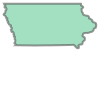

In [3]:
# this notebook uses rasterio Shapes for processing, so lets convert that geojson to a shape
aoi_shape = sgeom.shape(iowa['geometry'])
aoi_shape

## Build Request

Build the Planet API Filter request.

Customize this code for your own purposes

In [4]:
DATE_START = datetime.datetime(year=2017,month=1,day=1)
DATE_END = datetime.datetime(year=2017,month=9,day=1)

def build_request(aoi_shape, date_start=DATE_START, date_end=DATE_END, addl_filters=None):
    base_filters = [
        filters.geom_filter(sgeom.mapping(aoi_shape)),
        filters.range_filter('cloud_cover', lt=.1),
        filters.date_range('acquired', gt=date_start),
        filters.date_range('acquired', lt=date_end),
    ]
    
    if addl_filters is not None:
        base_filters += addl_filters

    query = filters.and_filter(*base_filters)
    
    item_types = ['PSOrthoTile']
    return filters.build_search_request(query, item_types)

request = build_request(aoi_shape)
# print(request)

## Set Coverage Grid Dimensions

Set the grid dimensions according to the AOI shape and the resolution of interest

In [5]:
dimensions = (3000, 4000)

## Search Planet API

The client is how we interact with the planet api. It is created with the user-specific api key, which is pulled from $PL_API_KEY environment variable.

In [6]:
def get_api_key():
    return os.environ['PL_API_KEY']


# quick check that key is defined
assert get_api_key(), "PL_API_KEY not defined."

In [7]:
import json

In [8]:
def create_client():
    return api.ClientV1(api_key=get_api_key())


def search_pl_api(request, limit=500):
    client = create_client()
    result = client.quick_search(request)
    
    # note that this returns a generator
    return result.items_iter(limit=limit)

item = next(search_pl_api(build_request(aoi_shape), limit=1))
print(json.dumps(item['properties']))

{"grid_cell": "1558315", "acquired": "2017-08-31T16:15:59.459616Z", "satellite_id": "102e", "sun_elevation": 48.3, "pixel_resolution": 3.125, "rows": 8000, "epsg_code": 32615, "usable_data": 0.02, "ground_control": true, "provider": "planetscope", "anomalous_pixels": 0, "columns": 8000, "updated": "2018-03-12T22:59:16Z", "cloud_cover": 0.001, "black_fill": 0.98, "sun_azimuth": 134.7, "origin_y": 4632500, "origin_x": 499500, "view_angle": 0.7, "strip_id": "723855", "item_type": "PSOrthoTile", "gsd": 4, "published": "2018-03-12T22:59:16Z"}


## Calculate Coverage

First query the planet api for the items that match the request defined above, then calculate the overlap between each item and the aoi. Finally, convert each overlap to a grid using [`rasterio.rasterize`](https://mapbox.github.io/rasterio/topics/features.html#burning-shapes-into-a-raster), accumulate coverage over the overlap grids, and display the coverage grid.

In [9]:
def calculate_overlap(item, aoi_shape):
    footprint_shape = sgeom.shape(item['geometry'])
    return aoi_shape.intersection(footprint_shape)

def calculate_overlaps(items, aoi_shape):
    item_num = 0
    overlap_num = 0
    for i in items:
        item_num += 1
        overlap = calculate_overlap(i, aoi_shape)
        if not overlap.is_empty:
            overlap_num += 1
            yield overlap
    print('{} overlaps from {} items'.format(overlap_num, item_num))

In [10]:
def calculate_coverage(overlaps, dimensions, bounds):
    
    # get dimensions of coverage raster
    mminx, mminy, mmaxx, mmaxy = bounds

    y_count, x_count = dimensions
    
    # determine pixel width and height for transform
    width = (mmaxx - mminx) / x_count
    height = (mminy - mmaxy) / y_count # should be negative

    # Affine(a, b, c, d, e, f) where:
    # a = width of a pixel
    # b = row rotation (typically zero)
    # c = x-coordinate of the upper-left corner of the upper-left pixel
    # d = column rotation (typically zero)
    # e = height of a pixel (typically negative)
    # f = y-coordinate of the of the upper-left corner of the upper-left pixel
    # ref: http://www.perrygeo.com/python-affine-transforms.html
    transform = rasterio.Affine(width, 0, mminx, 0, height, mmaxy)
    
    coverage = np.zeros(dimensions, dtype=np.uint16)
    for overlap in overlaps:
        if not overlap.is_empty:
            # rasterize overlap vector, transforming to coverage raster
            # pixels inside overlap have a value of 1, others have a value of 0
            overlap_raster = rfeatures.rasterize(
                    [sgeom.mapping(overlap)],
                    fill=0,
                    default_value=1,
                    out_shape=dimensions,
                    transform=transform)
            
            # add overlap raster to coverage raster
            coverage += overlap_raster
    return coverage

In [11]:
items = search_pl_api(request = build_request(aoi_shape),
                      limit=10000)
overlaps = calculate_overlaps(items, aoi_shape)

# cache coverage calculation because it takes a little while to create
coverage = calculate_coverage(overlaps, dimensions, aoi_shape.bounds)

9842 overlaps from 10000 items


In [12]:
from scipy import stats as sstats

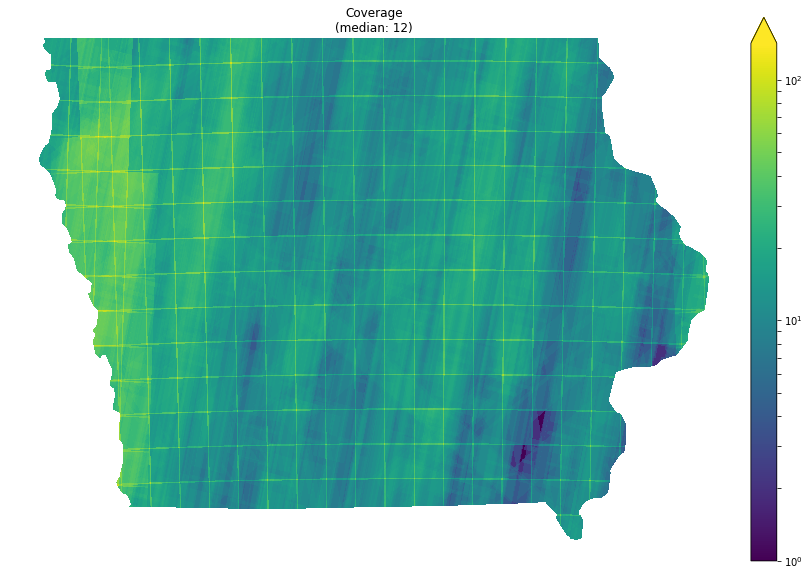

In [14]:
import matplotlib.colors as colors

def plot_coverage(coverage):
    fig, ax = plt.subplots(figsize=(15,10))
    
    # ref: https://matplotlib.org/users/colormapnorms.html
    pcm = ax.imshow(coverage,
                       interpolation='nearest',
                       norm=colors.LogNorm(vmin=max(1, coverage.min()), # avoid divide by zero
                                           vmax=coverage.max()),
                       cmap=cm.viridis)
    fig.colorbar(pcm, ax=ax, extend='max')
    fig.show()

    ax.set_title('Coverage\n(median: {})'.format(int(np.median(coverage))))
    ax.axis('off')

plot_coverage(coverage)

Even when we limit the query to 10,000 scenes (there are more scenes than that, but it takes quite some time to process that many scenes), there are areas in Iowa that have 10-100 scenes of coverage. Pretty awesome!